In [13]:
# torch

import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from torchvision.transforms import transforms
import torch.optim as optim
# utils


from PIL import Image

from sklearn.model_selection import train_test_split

In [14]:
# Step 1: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Step 2: Import required libraries
import torch
from glob import glob
import os
import random

# Step 3: Set device
device = "cuda" if torch.cuda.is_available() else "cpu"

# Step 4: Define dataset path
dataset_path = "/content/drive/MyDrive/Data"  # Make sure "Data" has "Normal" and "Stroke" subfolders

# Step 5: Set image size and number of classes
image_size = (224, 224)
num_classes = 2

# Step 6: Get all image paths from both folders (Normal and Stroke)
normal_image_paths = glob(os.path.join(dataset_path, "Normal", "*.jpg"))
stroke_image_paths = glob(os.path.join(dataset_path, "Stroke", "*.jpg"))

# Step 7: Combine the paths and shuffle
image_paths = normal_image_paths + stroke_image_paths
random.shuffle(image_paths)

# Step 8: Split the image paths into train and test sets
train_ratio = 0.8  # 80% for training
train_size = int(train_ratio * len(image_paths))
train_paths = image_paths[:train_size]
test_paths = image_paths[train_size:]

# Step 9: Output device and dataset stats
print("Device:", device)
print(f"Total images: {len(image_paths)}")
print(f"Training set size: {len(train_paths)}")
print(f"Testing set size: {len(test_paths)}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Device: cpu
Total images: 2501
Training set size: 2000
Testing set size: 501


In [15]:
# data augmentation
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(10),
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [16]:
# custom dataset class
class dataset(Dataset):
    def __init__(self,paths,transform=None):
        self.paths = paths
        self.transform = transform
        self.labels = [self.get_label(path) for path in self.paths]
        self.labels_to_index = {label:index for index,label in enumerate(list(set(self.labels)))}

    def __getitem__(self,index):
        img_path = self.paths[index]
        img = Image.open(img_path).convert('RGB')
        label = self.labels[index]
        label_index = self.labels_to_index[label]

        if self.transform:
            img = self.transform(img)

        return img, label_index,label


    def __len__(self):
        return len(self.paths)


    def get_label(self, path):
        return os.path.basename(os.path.dirname(path))

In [17]:
train_dataset = dataset(train_paths, transform=train_transform)
test_dataset = dataset(test_paths, transform=test_transform)
val_dataset, test_dataset = train_test_split(test_dataset,test_size=0.5)

In [18]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

## CNN

In [22]:
class MyModel(nn.Module):
    def __init__(self,num_classes):
        super(MyModel,self).__init__()

        self.conv1 = nn.Conv2d(3,32,kernel_size=4,stride=1,padding=0)
        self.bn1 = nn.BatchNorm2d(32)

        self.conv2 = nn.Conv2d(32,64,kernel_size=4,stride=1,padding=0)
        self.bn2 = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(64,128,kernel_size=4,stride=1,padding=0)
        self.bn3 = nn.BatchNorm2d(128)

        self.conv4 = nn.Conv2d(128,128,kernel_size=4,stride=1,padding=0)
        self.bn4 = nn.BatchNorm2d(128)

        self.pool = nn.MaxPool2d(kernel_size=3, stride=3)
        self.pool2= nn.MaxPool2d(kernel_size=3, stride=2)

        self.fc1 = nn.Linear(6*6*128,512)
        self.fc2 = nn.Linear(512,num_classes)

        self.flatten = nn.Flatten()
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)




    def forward(self,x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = self.relu(self.bn3(self.conv3(x)))
        x = self.pool2(x)
        x = self.relu(self.bn4(self.conv4(x)))
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

model = MyModel(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=0.0002)


Epoch 0,   Train Loss: 0.6874, Train Accuracy: 59.95%
Eval Loss: 0.6403, Eval Accuracy: 63.60%
######################################################################
Epoch 1,   Train Loss: 0.6336, Train Accuracy: 64.65%
Eval Loss: 0.6145, Eval Accuracy: 66.00%
######################################################################
Epoch 2,   Train Loss: 0.6170, Train Accuracy: 66.60%
Eval Loss: 0.6454, Eval Accuracy: 63.60%
######################################################################
Epoch 3,   Train Loss: 0.5871, Train Accuracy: 68.80%
Eval Loss: 0.5573, Eval Accuracy: 68.80%
######################################################################
Epoch 4,   Train Loss: 0.5662, Train Accuracy: 68.60%
Eval Loss: 0.6383, Eval Accuracy: 63.20%
######################################################################
Epoch 5,   Train Loss: 0.5513, Train Accuracy: 69.40%
Eval Loss: 0.6357, Eval Accuracy: 63.20%
######################################################################
Epoc

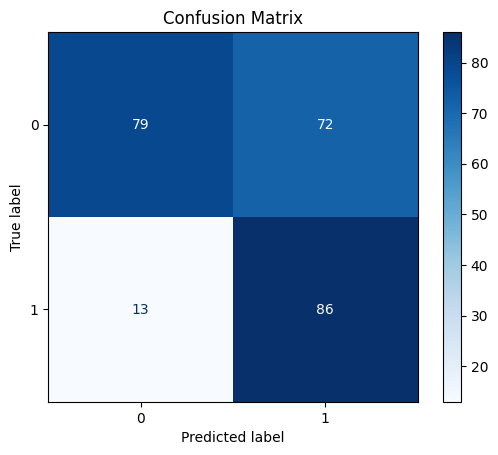

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.52      0.65       151
           1       0.54      0.87      0.67        99

    accuracy                           0.66       250
   macro avg       0.70      0.70      0.66       250
weighted avg       0.73      0.66      0.66       250



In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# Assuming these lists are defined somewhere in your code
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []


best_score = float("inf")
n_epochs = 10
tolerance = 0

def train_epoch():
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    for batch in train_loader:
        data = batch[0].to(device)
        labels = batch[1].to(device)

        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct_predictions += torch.sum(preds == labels).item()
        total_predictions += labels.size(0)

    avg_loss = running_loss / len(train_loader)
    accuracy = correct_predictions / total_predictions

    return avg_loss, accuracy

def eval_model():
    model.eval()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        for batch in val_loader:
            data = batch[0].to(device)
            labels = batch[1].to(device)

            outputs = model(data)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct_predictions += torch.sum(preds == labels).item()
            total_predictions += labels.size(0)

    avg_loss = running_loss / len(val_loader)
    accuracy = correct_predictions / total_predictions

    return avg_loss, accuracy

def get_predictions_and_labels():
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch in val_loader:
            data = batch[0].to(device)
            labels = batch[1].to(device)
            outputs = model(data)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return all_preds, all_labels

for epoch in range(n_epochs):
    print(f"Epoch {epoch},   ", end="")
    avg_train_loss, train_accuracy = train_epoch()
    avg_eval_loss, eval_accuracy = eval_model()

    if avg_eval_loss < best_score:
        best_score = avg_eval_loss
        torch.save(model.state_dict(), f"model_{epoch+1}.pt")
        tolerance = 0
    else:
        tolerance += 1
        if tolerance >= 8:
            break

    train_losses.append(avg_train_loss)
    val_losses.append(avg_eval_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(eval_accuracy)

    print(f"Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy * 100:.2f}%")
    print(f"Eval Loss: {avg_eval_loss:.4f}, Eval Accuracy: {eval_accuracy * 100:.2f}%")
    print("#" * 70)

# Generate predictions and true labels
preds, true_labels = get_predictions_and_labels()
# Compute confusion matrix
cm = confusion_matrix(true_labels, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


# Print classification report
print("Classification Report:")
print(classification_report(true_labels, preds))


## DNN (Deep neural networks)

✅ Trains a Deep Neural Network (DNN) with 5 fully connected layers

✅ Applies Softmax during prediction

✅ Displays confusion matrix, classification report, and confidence scores

✅ Allows inference on a custom image

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Device: cpu
Total: 2501 | Train: 2000 | Val: 250 | Test: 251
Epoch 1
Train Loss: 0.6857, Train Acc: 58.20%
Val Loss:   0.6280, Val Acc:   66.40%
############################################################
Epoch 2
Train Loss: 0.6479, Train Acc: 63.40%
Val Loss:   0.5937, Val Acc:   70.40%
############################################################
Epoch 3
Train Loss: 0.6180, Train Acc: 66.00%
Val Loss:   0.5772, Val Acc:   72.00%
############################################################
Epoch 4
Train Loss: 0.5905, Train Acc: 68.55%
Val Loss:   0.5930, Val Acc:   67.20%
############################################################
Epoch 5
Train Loss: 0.5650, Train Acc: 70.40%
Val Loss:   0.5575, Val Acc:   69.60%
############################################################
Epoch 6
Train Loss: 0.5256, Train Acc: 73.15%
Val Loss:   0.5464, Val Acc:   76.00%
#

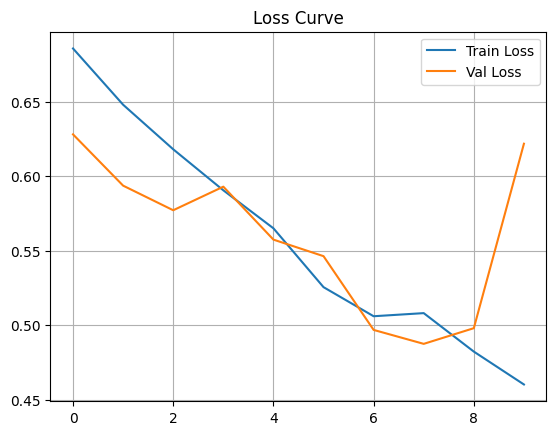

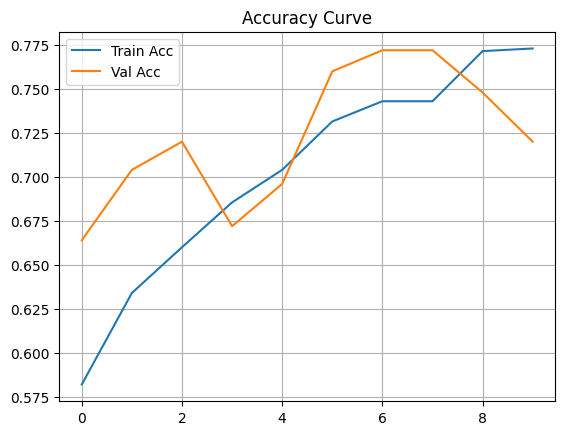

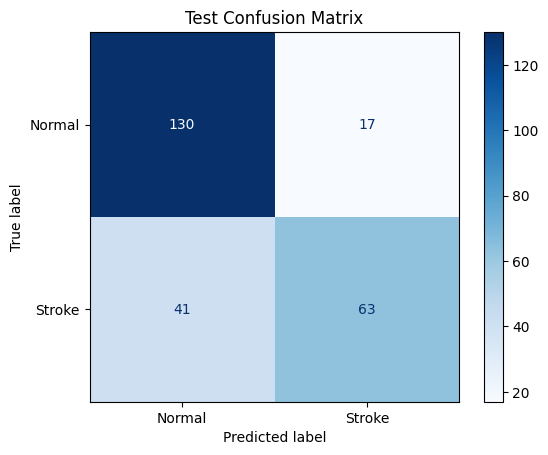

Test Classification Report:
              precision    recall  f1-score   support

      Normal       0.76      0.88      0.82       147
      Stroke       0.79      0.61      0.68       104

    accuracy                           0.77       251
   macro avg       0.77      0.75      0.75       251
weighted avg       0.77      0.77      0.76       251



In [24]:
# STEP 1: SETUP
from google.colab import drive
drive.mount('/content/drive')

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from glob import glob
import os
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

# STEP 2: PATHS AND SETTINGS
dataset_path = "/content/drive/MyDrive/Data"
image_size = (224, 224)
num_classes = 2

# STEP 3: LOAD IMAGE PATHS
normal_paths = glob(os.path.join(dataset_path, "Normal", "*.jpg"))
stroke_paths = glob(os.path.join(dataset_path, "Stroke", "*.jpg"))
image_paths = normal_paths + stroke_paths
random.shuffle(image_paths)

# STEP 4: SPLIT DATA
train_ratio = 0.8
train_size = int(train_ratio * len(image_paths))
train_paths = image_paths[:train_size]
test_paths = image_paths[train_size:]
val_paths, test_paths = train_test_split(test_paths, test_size=0.5)

print(f"Total: {len(image_paths)} | Train: {len(train_paths)} | Val: {len(val_paths)} | Test: {len(test_paths)}")

# STEP 5: TRANSFORMS
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(10),
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# STEP 6: DATASET CLASS
class StrokeDataset(Dataset):
    def __init__(self, paths, transform=None):
        self.paths = paths
        self.transform = transform
        self.labels = [self.get_label(p) for p in paths]
        self.label_map = {'Normal': 0, 'Stroke': 1}

    def get_label(self, path):
        return os.path.basename(os.path.dirname(path))

    def __getitem__(self, index):
        img = Image.open(self.paths[index]).convert('RGB')
        if self.transform:
            img = self.transform(img)
        label_name = self.get_label(self.paths[index])
        label = self.label_map[label_name]
        return img, label

    def __len__(self):
        return len(self.paths)

# STEP 7: LOADERS
train_dataset = StrokeDataset(train_paths, transform=train_transform)
val_dataset = StrokeDataset(val_paths, transform=test_transform)
test_dataset = StrokeDataset(test_paths, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# STEP 8: DNN MODEL
class DNNModel(nn.Module):
    def __init__(self, num_classes):
        super(DNNModel, self).__init__()
        self.flatten = nn.Flatten()
        self.fc_layers = nn.Sequential(
            nn.Linear(224 * 224 * 3, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.4),

            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc_layers(x)
        return x

# STEP 9: INITIALIZE MODEL
model = DNNModel(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0002)

# STEP 10: TRAINING FUNCTIONS
train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []
best_score = float("inf")
n_epochs = 10
tolerance = 0

def train_epoch():
    model.train()
    running_loss, correct, total = 0, 0, 0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    return running_loss / len(train_loader), correct / total

def eval_model():
    model.eval()
    running_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return running_loss / len(val_loader), correct / total

# STEP 11: TRAIN LOOP
for epoch in range(n_epochs):
    print(f"Epoch {epoch+1}")
    train_loss, train_acc = train_epoch()
    val_loss, val_acc = eval_model()

    if val_loss < best_score:
        best_score = val_loss
        torch.save(model.state_dict(), f"best_dnn_model.pt")
        tolerance = 0
    else:
        tolerance += 1
        if tolerance >= 5:
            break

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2%}")
    print(f"Val Loss:   {val_loss:.4f}, Val Acc:   {val_acc:.2%}")
    print("#" * 60)

# STEP 12: PLOTS
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title("Loss Curve")
plt.legend()
plt.grid()
plt.show()

plt.plot(train_accuracies, label='Train Acc')
plt.plot(val_accuracies, label='Val Acc')
plt.title("Accuracy Curve")
plt.legend()
plt.grid()
plt.show()

# STEP 13: TEST EVALUATION
def get_predictions(loader):
    model.eval()
    preds, labels = [], []
    with torch.no_grad():
        for imgs, lbls in loader:
            imgs = imgs.to(device)
            outputs = model(imgs)
            _, p = torch.max(outputs, 1)
            preds.extend(p.cpu().numpy())
            labels.extend(lbls.numpy())
    return preds, labels

model.load_state_dict(torch.load("best_dnn_model.pt"))
test_preds, test_labels = get_predictions(test_loader)

# Confusion Matrix
cm = confusion_matrix(test_labels, test_preds)
disp = ConfusionMatrixDisplay(cm, display_labels=["Normal", "Stroke"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Test Confusion Matrix")
plt.show()

# Classification Report
print("Test Classification Report:")
print(classification_report(test_labels, test_preds, target_names=["Normal", "Stroke"]))


✅ Apply Softmax during prediction

✅ Display class probabilities (confidence scores)


In [25]:
# STEP 14: SOFTMAX-BASED EVALUATION
import torch.nn.functional as F
import numpy as np

def get_predictions_with_softmax(loader):
    model.eval()
    all_probs, all_preds, all_labels = [], [], []
    with torch.no_grad():
        for imgs, labels in loader:
            imgs = imgs.to(device)
            outputs = model(imgs)
            probs = F.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1)
            all_probs.extend(probs.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())
    return np.array(all_preds), np.array(all_labels), np.array(all_probs)

# Load best model weights before evaluation
model.load_state_dict(torch.load("best_dnn_model.pt"))

# Get predictions using Softmax
test_preds, test_labels, test_probs = get_predictions_with_softmax(test_loader)

# STEP 15: DISPLAY SOFTMAX CONFIDENCE
print("\nSample Softmax Predictions:")
class_names = ["Normal", "Stroke"]
for i in range(5):  # Show 5 predictions
    print(f"Predicted: {class_names[test_preds[i]]}, Probabilities: {test_probs[i]}")



Sample Softmax Predictions:
Predicted: Normal, Probabilities: [0.8952447  0.10475523]
Predicted: Normal, Probabilities: [0.6368154  0.36318457]
Predicted: Normal, Probabilities: [0.8916373  0.10836264]
Predicted: Normal, Probabilities: [0.54651296 0.453487  ]
Predicted: Stroke, Probabilities: [0.13180628 0.86819375]


## Predict on a Custom Image

In [26]:
# STEP 16: INFERENCE ON SINGLE CUSTOM IMAGE
from PIL import Image

def predict_custom_image(img_path):
    model.eval()
    img = Image.open(img_path).convert("RGB")
    img_tensor = test_transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(img_tensor)
        probs = F.softmax(output, dim=1)
        pred = torch.argmax(probs, dim=1).item()
        confidence = probs[0][pred].item()

    print(f"Predicted Class: {class_names[pred]}")
    print(f"Confidence Score: {confidence:.4f}")
    print(f"All Probabilities: {probs.cpu().numpy()[0]}")

# Example usage:
predict_custom_image("/content/drive/MyDrive/Data/Stroke/58 (10).jpg")


Predicted Class: Normal
Confidence Score: 0.7544
All Probabilities: [0.7543874  0.24561268]
